# Merging Blocks using Plot3D
With large meshes, it can be more efficient to minimize the number of blocks and send larger blocks to the CPU or GPU instead. This tutorial shows how to perform that combination automatically or manually

## Download an example mesh

In [1]:
!wget https://nasa-public-data.s3.amazonaws.com/plot3d_utilities/iso65_64blocks.xyz

--2025-07-17 17:30:04--  https://nasa-public-data.s3.amazonaws.com/plot3d_utilities/iso65_64blocks.xyz
Resolving nasa-public-data.s3.amazonaws.com (nasa-public-data.s3.amazonaws.com)... 3.5.27.168, 3.5.29.24, 54.231.199.145, ...
Connecting to nasa-public-data.s3.amazonaws.com (nasa-public-data.s3.amazonaws.com)|3.5.27.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3773956 (3.6M) [binary/octet-stream]
Saving to: ‘iso65_64blocks.xyz’

iso65_64blocks.xyz  100%[===================>]   3.60M  23.9MB/s    in 0.2s    

2025-07-17 17:30:04 (23.9 MB/s) - ‘iso65_64blocks.xyz’ saved [3773956/3773956]



## Install Plot3D

In [2]:
!pip install plot3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 kB 1.7 MB/s eta 0:00:00


In [3]:
import os
from plot3d import write_plot3D, read_plot3D, split_blocks, combine_nxnxn_cubes_mixed_pairs
from plot3d import connectivity_fast, plot_blocks, find_matching_faces
import pickle
import numpy as np

METIS_DLL is not set. metis may not be configured. plot3D will function without metis


## Find the connectivity between the blocks
This is required for CFD solving and for merging blocks

In [5]:
blocks = read_plot3D('iso65_64blocks.xyz',binary=True,read_double=False)
# Block 1 is the blade O-Mesh k=0
# outer_faces, _ = get_outer_faces(blocks[0]) # lets check
face_matches, outer_faces_formatted = connectivity_fast(blocks)
test = np.array([(c['block1']['block_index'],c['block2']['block_index'])  for c in face_matches])
print(f'minimum block index: {test.min()}')
with open('connectivity.pickle','wb') as f:
    [m.pop('match',None) for m in face_matches] # Remove the dataframe
    pickle.dump({"face_matches":face_matches, "outer_faces":outer_faces_formatted},f)
write_plot3D('iso65_64blocks-ASCII.xyz', blocks,binary = False)

gcd to use 16


Checking connections block 63 with 60: 100%|██████████| 384/384 [00:08<00:00, 42.91it/s]


minimum block index: 0


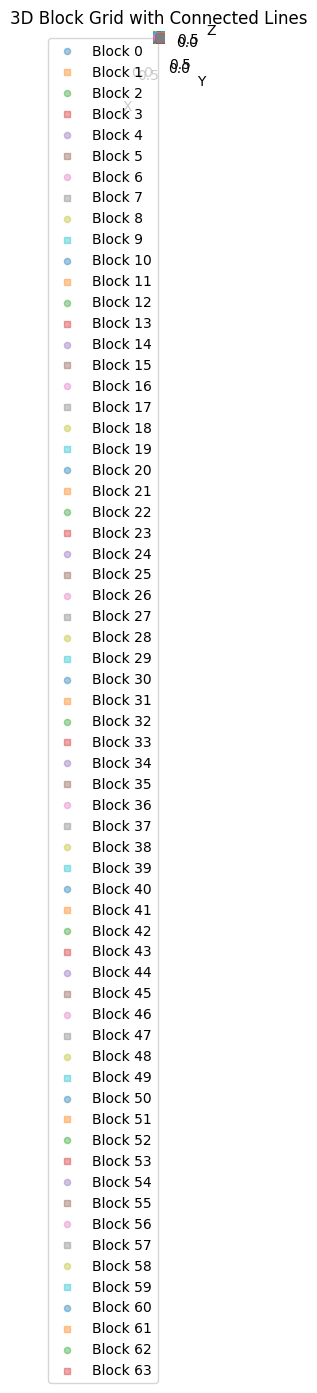

In [7]:
# Plot the original blocks
plot_blocks(blocks) # this function accepts an array

## Combine blocks
The code below automatically finds connected blocks and merges blocks together so 2x2x2 creates a rubix cube size 8 and 3x3x3 creates a rubix cube with 27 blocks.

**In the example below, try playing with the cube size and plot the blocks. You should see the colors changing.**

In [12]:

merged_face_matches = face_matches
merged_outer_faces = outer_faces_formatted
merged_block_only = blocks

for i in range(1): # Loop and find new pairs
    merged = combine_nxnxn_cubes_mixed_pairs(merged_block_only, merged_face_matches,cube_size=2)
    merged_blocks_only = [m[0] for m in merged]
    face_matches_2x2x2, outer_faces_formatted_2x2x2 = connectivity_fast(merged_blocks_only)
    write_plot3D("merged_2x2x2.xyz",merged_blocks_only,binary=False)

    test = np.array([(c['block1']['block_index'],c['block2']['block_index'])  for c in merged_face_matches])
    print(f'minimum block index: {test.min()}')
    [m.pop('match',None) for m in merged_face_matches] # Remove the dataframe
    print(f'Merge pass {i} number of blocks {len(merged_blocks_only)}')

    with open('merged_connectivity.pickle','wb') as f:
        pickle.dump(
            {
                "face_matches":merged_face_matches,
                "outer_faces":merged_outer_faces,
                "blocks":merged_blocks_only
            },f)

✅ No further merges possible. Appending unmerged blocks.
gcd to use 32


Checking connections block 3 with 0: 100%|██████████| 12/12 [00:00<00:00, 17.95it/s]


minimum block index: 0
Merge pass 0 number of blocks 4
✅ No further merges possible. Appending unmerged blocks.
gcd to use 32


Checking connections block 3 with 0: 100%|██████████| 12/12 [00:00<00:00, 20.73it/s]


minimum block index: 0
Merge pass 1 number of blocks 4


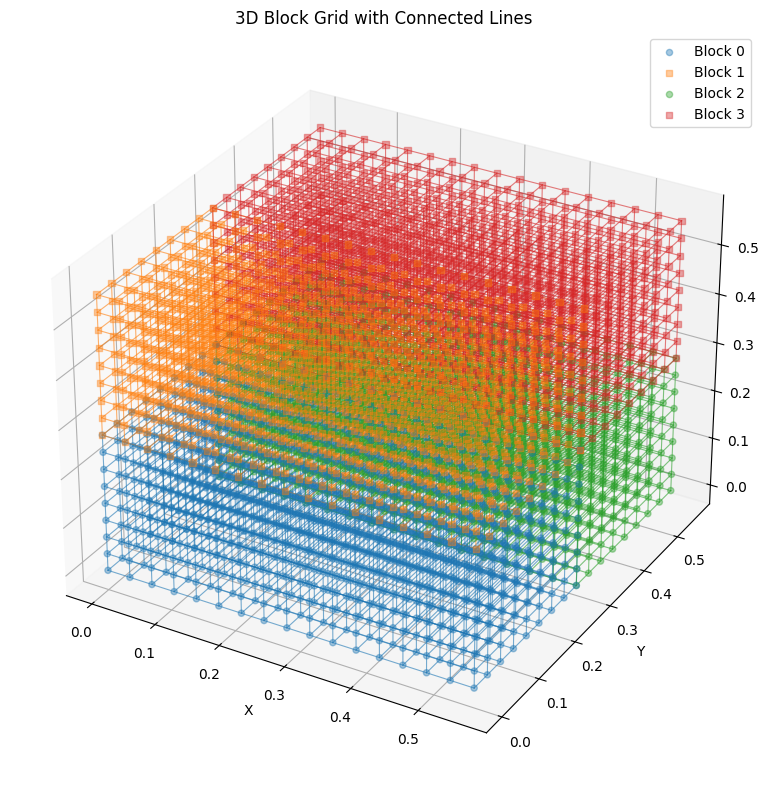

In [13]:
plot_blocks(merged_blocks_only)